In [1]:
from pathlib import Path
from math import sqrt

import numpy as np
import pandas as pd

from numba import njit

from matplotlib import pyplot as plt

In [2]:
def one_hot(n, i):
    q = np.zeros(n)
    q[i] = 1.0
    return q

In [3]:
train_data = np.loadtxt(Path('/mnt/HDD500GB/Data/development/jupyterLab/data/mnist_train_small.csv'), delimiter=',')
test_data = np.loadtxt(Path('/mnt/HDD500GB/Data/development/jupyterLab/data/mnist_test.csv'), delimiter=',')

In [4]:
x_train = train_data[:,1:] / 255.0
y_train = np.array([one_hot(10, int(i)) for i in train_data[:,0]])

x_test = test_data[:,1:] / 255.0
y_test = np.array([one_hot(10, int(i)) for i in test_data[:,0]])

### Define functions

In [5]:
@njit(fastmath=True)
def norm(x: np.ndarray) -> float:
    return sqrt(np.sum(np.square(x)))


@njit(fastmath=True)
def cosim(a: np.ndarray, b: np.ndarray) -> float:
    return (a @ b) / (norm(a) * norm(b))


@njit(fastmath=True)
def mcosim(m: np.ndarray, x: np.ndarray) -> float:
    y = np.zeros(m.shape[0])
    x_norm = norm(x)
    
    for i in range(m.shape[0]):
        y[i] = (m[i] @ x) / (norm(m[i]) * x_norm)
        
    return y


@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))


@njit(fastmath=True)
def dSigmoid(x: np.ndarray) -> np.ndarray:
    y = 1 / (1 + np.exp(-x))
    return y * (1 - y)


@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y / np.sum(y)

### Define model

In [6]:
@njit(fastmath=True)
def grads(x_batch: np.ndarray, y_batch: np.ndarray, W: np.ndarray) -> np.ndarray:
    dW = np.zeros(W.shape)

    h = np.zeros((W.shape[0], W.shape[2]))

    for i in range(x_batch.shape[0]):
        for j in range(W.shape[0]):
            h[j] = W[j].T @ y_batch[i]

        z = np.sum(h, axis=0)

        dLdz = 2 * (z - x_batch[i])
        dLdw = np.outer(y_batch[i], dLdz)

        for j in range(W.shape[0]):
            dW[j] += dLdw

    return dW


class Perceptron:
    def __init__(self, nIn: int, nOut: int, nL: int) -> None:
        self.nIn: int = nIn
        self.nOut: int = nOut
        self.nL: int = nL

        self.W: np.ndarray = np.random.uniform(-1, 1, (nL, nOut, nIn))

    def predict(self, x: np.ndarray) -> np.ndarray:
        w = np.sum(self.W, axis=0)
        return mcosim(w, x)

    def loss(self, x: np.ndarray, y: np.ndarray) -> float:
        ypred = np.array([self.predict(xi) for xi in x])
        h = -np.mean(y * np.log(ypred), axis=1)
        return np.mean(h)

    def train(self, x_train: np.ndarray, y_train: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = x_train.shape[0]

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)
            n_batches = n // batch_size

            for i in range(n_batches):
                ibegin = i * batch_size
                iend = min((i + 1) * batch_size, n - 1)
                batch_idxs = idxs[ibegin:iend]

                dW  = grads(x_train[batch_idxs], y_train[batch_idxs], self.W)

                self.W -= lr * dW

### Create and train model

In [9]:
nIn = 784
nOut = 10
nL = 3

learning_rate = 1e-3
batch_size = 256
max_epoch = 10

model = Perceptron(nIn, nOut, nL)

model.train(x_train, y_train, learning_rate, batch_size, max_epoch)

print('trained loss: ', model.loss(x_test, y_test).round(5))

n_true_pos = 0

for x, y in zip(x_test, y_test):
    ypred = model.predict(x)
    n_true_pos += 1 if np.argmax(ypred) == np.argmax(y) else 0

accuracy = round(n_true_pos / x_test.shape[0] * 100, 2)
print(f"test set accuracy: {accuracy}%")

trained loss:  0.03236
test set accuracy: 82.27%


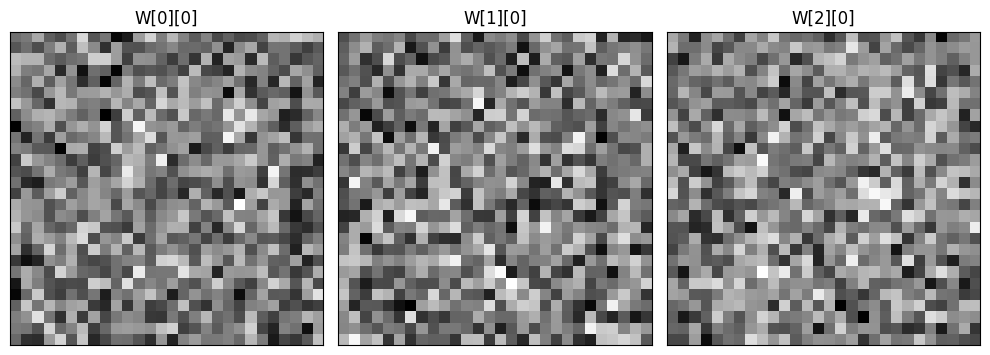

In [14]:
img_size = 784
img_shape = (28, 28)

fig, axes = plt.subplots(nrows=1, ncols=model.nL)
fig.set_figwidth(10)
fig.set_figheight(5)
fig.set_dpi(100)

idx = 0

for i in range(model.nL):
    img = axes[i].imshow(model.W[i][idx].reshape(img_shape), cmap='binary_r')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title(f'W[{i}][{idx}]')

plt.tight_layout()
plt.show()

In [15]:
w = np.sum(model.W, axis=0)

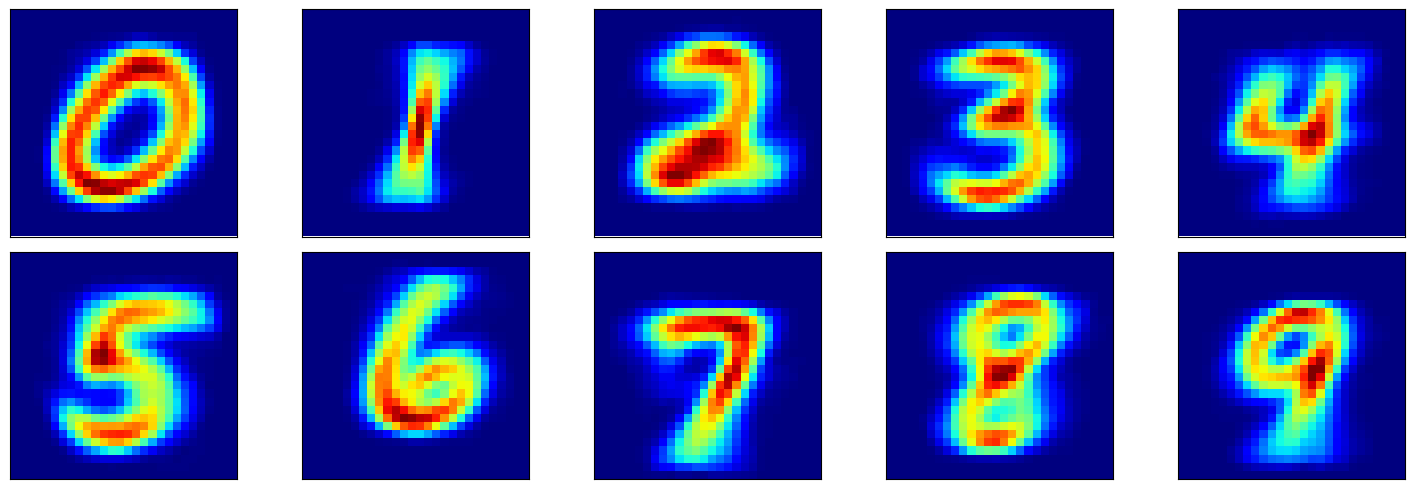

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=5)

fig.set_dpi(100)
fig.set_figwidth(15)
fig.set_figheight(5)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(w[i].reshape(img_shape),  cmap='jet')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()